# Data Preprocessing

In [1]:
# some magic so that the notebook will reload external python modules;
# see https://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
import os
import subprocess
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from copy import copy
import gc
import glob
import json
import string
import math

import cv2
import torch

In [3]:
from data_processing.video_utils import seconds_to_hhmmss, clip_video_ffmpeg

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


## Getting Face Tracks

In [5]:
from data_processing.face_tracks import get_single_face_tracks
from data_processing.video_utils import clip_video_ffmpeg

In [6]:
def crop_frame(frame, speaker):
	if speaker == "chem" or speaker == "hs":
		return frame
	elif speaker == "chess":
		H, W = frame.shape[:2]
		return frame[H//3:, W//2:]
		# return frame[270:460, 770:1130]
	elif speaker == "dl" or speaker == "eh":
		return  frame[int(frame.shape[0]*3/4):, int(frame.shape[1]*3/4): ]
	else:
		raise ValueError("Unknown speaker!")
		exit()

In [7]:
# video_path = './data/-0ZMU-gnm2g.mp4'
# video_path = './datasets/Lip2Wav/hs/videos/yzropgAwSI0.mp4'
# video_path = './datasets/Lip2Wav/hs/videos/0Twy4dNfLVM.mp4'
# video_path = './datasets/Lip2Wav/chess/videos/KjZo4bLorsw.mp4'
# video_path = './datasets/Lip2Wav/chem/videos/0G0wCm28Jzc.mp4'
# video_path = '/home/vanshg/play/OSts9bfX6cA/track-2.mp4'
# video_path = '/home/vanshg/play/OSts9bfX6cA_2_25.mp4'
video_path = './datasets/Lip2Wav/dl/test_videos/test.mp4'

print(os.path.exists(video_path))
frames = []
cap = cv2.VideoCapture(video_path)

while len(frames) < 1000:
    ret, frame = cap.read()
    if not ret:
        break
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    # frame = crop_frame(frame, 'chess')
    frames.append(frame)

# frames = np.array(frames)

True


In [8]:
print(len(frames))

1000


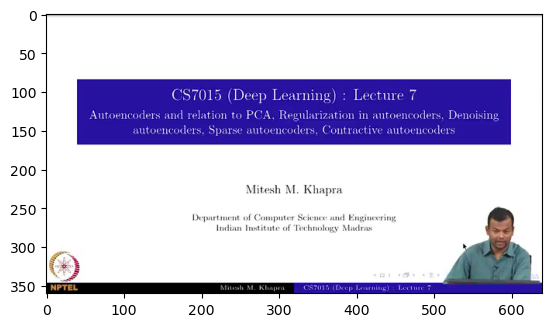

In [9]:
plt.imshow(frames[500])
plt.show()

### Using MediaPipe

In [43]:
import mediapipe as mp

In [114]:
mp_face_detection = mp.solutions.face_detection
full_range_detector = mp_face_detection.FaceDetection(min_detection_confidence=0.5, model_selection=1)

print(mp_face_detection)
print(full_range_detector)

<module 'mediapipe.python.solutions.face_detection' from '/home/vanshg/anaconda3/envs/coursework/lib/python3.10/site-packages/mediapipe/python/solutions/face_detection.py'>


I0000 00:00:1721241717.494488   53285 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1721241717.544889   88307 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.183.01), renderer: NVIDIA GeForce RTX 3050 6GB Laptop GPU/PCIe/SSE2


W0000 00:00:1721241717.557377   88304 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [76]:
def get_bbox_from_mp_detection(detection):
    bboxC = detection.location_data.relative_bounding_box
    x1, y1 = bboxC.xmin * 1000, bboxC.ymin * 1000
    w, h = bboxC.width * 1000, bboxC.height * 1000
    x2, y2 = x1 + w, y1 + h

    bbox = (int(x1), int(y1), int(x2), int(y2))
    return bbox

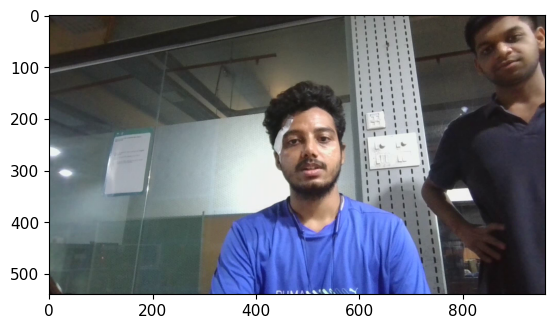

In [19]:
video_path = "./data/1.webm"

cap = cv2.VideoCapture(video_path)
ret, frame = cap.read()
frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

plt.imshow(frame_rgb)

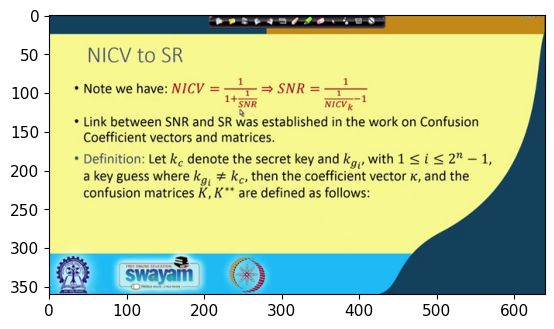

In [70]:
plt.imshow(frames[1700])
plt.show()

In [115]:
detector = full_range_detector
print(frames[87].shape)
results = full_range_detector.process(frames[275])
detected_faces = results.detections
bbox = get_bbox_from_mp_detection(detected_faces[0])
print(bbox)

(360, 640, 3)
(880, 728, 936, 828)


(360, 640, 3)


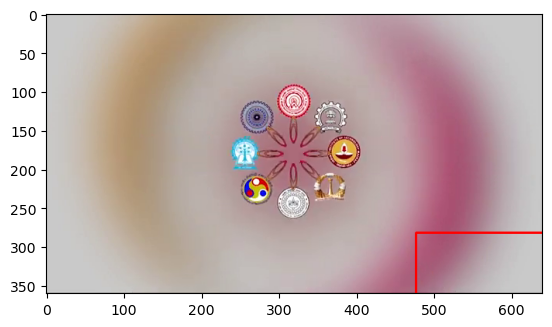

In [78]:
frame = copy.deepcopy(frames[87])
print(frame.shape)

(x1, y1, w, h) = bbox
cv2.rectangle(frame, (x1, y1), (x1 + w, y1 + h), color=(255, 0, 0), thickness=2)

plt.imshow(frame)

### Using RetinaFace

In [58]:
from ibug.face_alignment import FANPredictor
from ibug.face_detection import RetinaFacePredictor

In [59]:
model_name = "resnet50"
face_detector = RetinaFacePredictor(device=device, threshold=0.8, model=RetinaFacePredictor.get_model(model_name))

print(face_detector)

[]


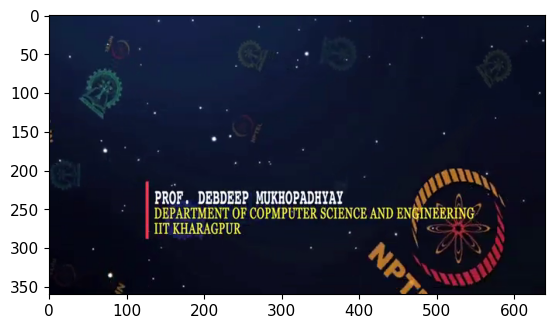

In [62]:
frame_idx = 254
detected_faces = face_detector(frames[frame_idx])
print(detected_faces)
plt.imshow(frames[frame_idx])
plt.show()

In [38]:
fps = int(cap.get(cv2.CAP_PROP_FPS))
print(fps)

15


frames.shape = (128, 360, 640, 3)


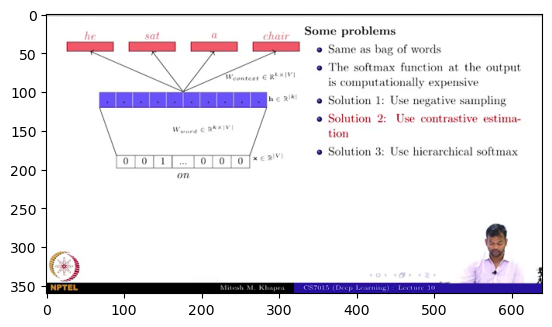

In [129]:
video_path = "./data/clip-1.mp4"

cap = cv2.VideoCapture(video_path)

frames = []
while cap.isOpened():
    ret, frame = cap.read()

    if not ret:
        break

    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frames.append(frame_rgb)

frames = np.array(frames)
print(f"{frames.shape = }")

plt.imshow(frames[0])
plt.show()

In [133]:
print(3/4 * 360)

270.0


(360, 640, 3)
(90, 160, 3)


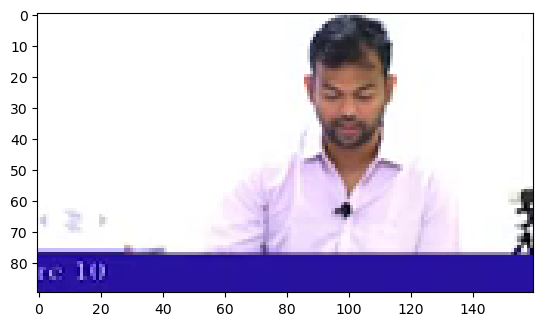

In [137]:
frame = frames[0]
print(frame.shape)
H, W = frame.shape[:2]
temp = frame[int(H * 3/4):, int(W * 3/4):, :]
print(temp.shape)
plt.imshow(temp)
plt.show()

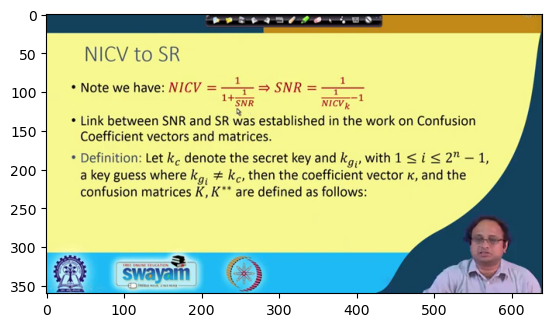

In [128]:
plt.imshow(frames[8])

In [51]:
# single_tracks = ["start_frame", "end_frame"]
tracks = []

for idx, frame in enumerate(frames):
    detected_faces = face_detector(frame, rgb=True)

    if len(detected_faces):
        detected_face = detected_faces[0]
        (x1, y1, x2, y2) = detected_face[:4]
        w, h = (x2 - x1), (y2 - y1)
        bbox = (x1, y1, w, h)

        if len(tracks):
            last_track = tracks[-1]
            last_track_frame = last_track['end_frame']
            if idx == last_track_frame + 1:
                last_track['end_frame'] = idx
                last_track['frames'].append(frame)
                last_track['bboxes'].append(bbox)
            else:
                print(f"New track started at frame idx: {idx}")
                new_track = {
                    "start_frame": idx,
                    "end_frame": idx,
                    "frames": [frame],
                    "bboxes": [bbox]
                }
                tracks.append(new_track)
        else:
            print(f"New track started at frame idx: {idx}")
            new_track = {
                "start_frame": idx,
                "end_frame": idx,
                "frames": [frame],
                "bboxes": [bbox]
            }
            tracks.append(new_track)


print(f"Total number of tracks = {len(tracks)}")

New track started at frame idx: 315
Total number of tracks = 1


In [8]:
tracks = get_single_face_tracks(frames, device)
print(f"Number of detected tracks = {len(tracks)}")

Processing Frames: 100%|██████████| 768/768 [00:18<00:00, 41.78it/s]

Number of detected tracks = 1


In [12]:
print(video_path)

./data/cut-0.mp4


In [19]:
track = tracks[0]
start_frame = track['start_frame']
end_frame = track['end_frame']
print(start_frame, end_frame)

fps = 15
start_time = int(start_frame/fps)
end_time = int(end_frame/fps) + 1

src_video_dir = os.path.dirname(video_path)

output_path = os.path.join(src_video_dir, "clip-1.mp4")

clip_video_ffmpeg(video_path, (start_time, end_time), output_path)

315 767


ffmpeg version 4.2.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/tmp/build/80754af9/ffmpeg_1587154242452/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeho --cc=/tmp/build/80754af9/ffmpeg_1587154242452/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --enable-avresample --enable-gmp --enable-hardcoded-tables --enable-libfreetype --enable-libvpx --enable-pthreads --enable-libopus --enable-postproc --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --disable-nonfree --enable-gpl --enable-gnutls --disable-openssl --enable-libopenh264 --enable-libx264
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100


128


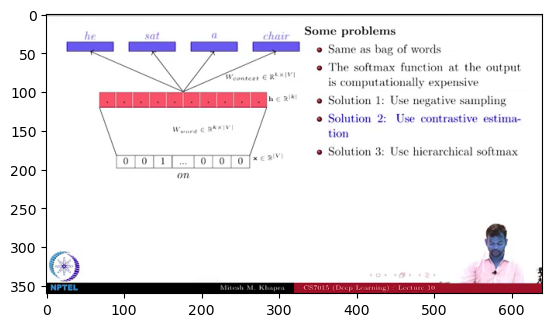

: 

In [22]:
new_vid_path = './data/clip-1.mp4'

new_frames = []
vid = cv2.VideoCapture(new_vid_path)

while vid.isOpened:
    ret, frame = vid.read()
    if not ret:
        break
    new_frames.append(frame)

print(len(new_frames))
plt.imshow(new_frames[0])

### Using Yolov5-face

In [10]:
def get_batch_prediction_yolov5(frames, face_detector):
     frames_bboxes = []
     bboxes, points = face_detector.predict(frames)

     for frame_bboxes in bboxes:
        frames_bboxes.append(np.array(frame_bboxes))

     return frames_bboxes

In [11]:
from preparation.detectors.yoloface.face_detector import YoloDetector

face_detector = YoloDetector(min_face=25)

cuda:0
/home/vanshg/play/IIITH/research-cvit/lip-reading/auto_avsr/preparation/detectors/yoloface/weights/yolov5n_state_dict.pt


In [12]:
bboxes = get_batch_prediction_yolov5(frames[500:532], face_detector)

In [13]:
print(len(bboxes))
print(bboxes[0].shape)
print(bboxes[0])

32
(1, 4)
[[570 263 602 304]]


[210, 54, 264, 124]


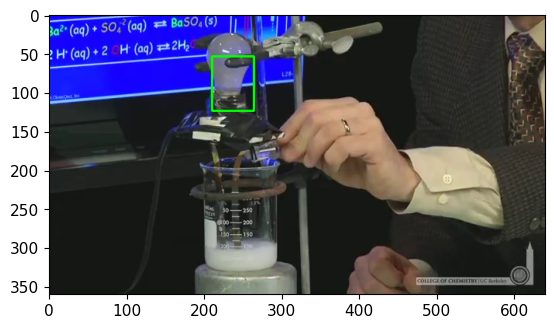

[[[210, 54, 264, 124]]]


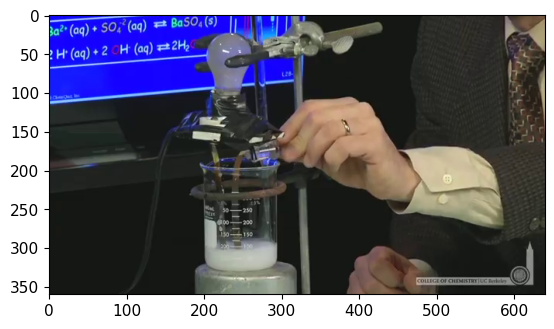

In [113]:
frame_idx = -17
frame = frames[frame_idx]
# frame = cv2.cvtColor(cv2.imread('./agadmator.png'), cv2.COLOR_BGR2RGB)
H, W = frame.shape[:2]
temp = frame.copy()

bboxes, points = face_detector.predict(frame)
if len(bboxes[0]):
    bbox = bboxes[0][0]
    print(bbox)
    (x1, y1, x2, y2) = bbox
    cv2.rectangle(temp, (x1, y1), (x2, y2), (0, 255, 0), thickness=2)
    plt.imshow(temp)
    plt.show()

print(bboxes)
plt.imshow(frame)
plt.show()

### Using Face Alignment Network

In [40]:
frames = np.array(frames)
print(frames.shape)

(2000, 240, 288, 3)


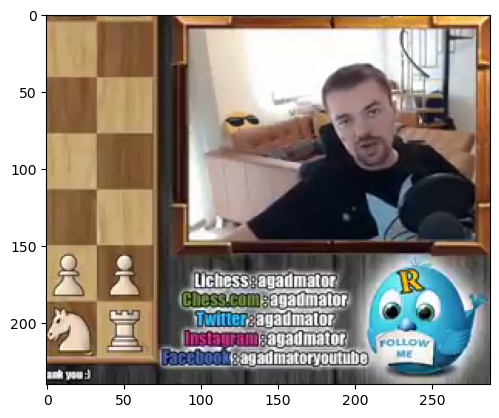

In [41]:
plt.imshow(frames[138])

In [11]:
import data_processing.face_detection as face_detection
face_detector = face_detection.FaceAlignment(face_detection.LandmarksType._2D, flip_input=False, device='cuda:0')

In [42]:
preds = face_detector.get_detections_for_batch(frames[1990:])

In [56]:
print(len(preds))
print(preds[0])

10
(array([[[ 72,  61,  58],
        [ 78,  67,  64],
        [103,  82,  82],
        [ 81,  60,  60],
        [ 82,  60,  63],
        [ 59,  37,  40],
        [ 32,  10,  15],
        [ 32,  10,  15],
        [ 30,  11,  15],
        [ 30,  11,  15],
        [ 25,  20,  19],
        [  0,   0,   0],
        [ 35,  33,  31],
        [ 68,  66,  64],
        [ 54,  49,  48]],

       [[ 80,  69,  66],
        [ 82,  71,  68],
        [ 73,  52,  52],
        [ 45,  24,  24],
        [ 72,  50,  53],
        [103,  81,  84],
        [103,  81,  86],
        [ 95,  73,  78],
        [ 78,  59,  63],
        [ 71,  52,  56],
        [ 36,  31,  30],
        [  5,   0,   0],
        [ 16,  14,  12],
        [ 21,  19,  17],
        [ 49,  44,  43]],

       [[ 89,  74,  63],
        [ 89,  74,  63],
        [ 72,  44,  33],
        [145, 117, 106],
        [216, 178, 170],
        [230, 192, 184],
        [223, 173, 167],
        [215, 165, 159],
        [201, 150, 140],
        [194, 143

## Getting transcripts from Whisper

In [ ]:
import whisper

In [20]:
video_path = './data/LHL5SkYONjg.mp4'

model = whisper.load_model('small')
result = model.transcribe(video_path)

In [27]:
print(type(result))
print(result.keys())
segments = result['segments']

print(type(segments), len(segments))
print(segments[5])

<class 'dict'>
dict_keys(['text', 'segments', 'language'])
<class 'list'> 194
{'id': 5, 'seek': 2684, 'start': 26.84, 'end': 31.12, 'text': " he doesn't get to go into the playoffs. So people who go into the playoffs are", 'tokens': [50364, 415, 1177, 380, 483, 281, 352, 666, 264, 41142, 13, 407, 561, 567, 352, 666, 264, 41142, 366, 50578], 'temperature': 0.0, 'avg_logprob': -0.19469501591530167, 'compression_ratio': 1.8373983739837398, 'no_speech_prob': 0.21479617059230804}


In [31]:
audio = whisper.load_audio(video_path)
audio = whisper.pad_or_trim(audio)

mel = whisper.log_mel_spectrogram(audio).to(model.device)
options = whisper.DecodingOptions(language="en", without_timestamps=False, fp16=False)
result = whisper.decode(model, mel, options)

In [37]:
print(type(result))
print(result)

<class 'whisper.decoding.DecodingResult'>
DecodingResult(audio_features=tensor([[-0.1800, -0.6548,  1.1791,  ..., -0.3529, -0.3710, -0.1378],
        [ 0.9183,  1.4822,  1.7061,  ..., -0.5757,  0.4751,  0.0989],
        [ 0.4328,  0.9152,  1.8110,  ..., -0.8506, -0.1808, -0.3569],
        ...,
        [ 1.4128, -0.0374,  4.4076,  ..., -0.1171,  0.6438,  1.8401],
        [ 0.1561,  0.9463,  3.7649,  ...,  1.2838,  0.2154,  0.2719],
        [-1.2362,  0.9978,  2.7442,  ...,  0.2634, -1.2946,  0.5222]],
       device='cuda:0'), language='en', language_probs=None, tokens=[50364, 2425, 1518, 293, 2928, 646, 281, 264, 43560, 388, 391, 27014, 4808, 13, 467, 311, 472, 295, 264, 50626, 50626, 11255, 295, 264, 4808, 11255, 13713, 11, 8979, 39, 1459, 5717, 5080, 12, 5294, 12, 2641, 50838, 50838, 7220, 6757, 21640, 4389, 3457, 43108, 293, 934, 1266, 13757, 456, 311, 257, 731, 3407, 51110, 51110, 561, 7582, 337, 700, 1081, 457, 787, 1451, 4150, 352, 666, 7582, 9857, 11, 3620, 51396, 51396, 300, 290

## Getting Transcriptions for WhisperX

In [3]:
import whisperx

2024-07-19 19:13:19.086396: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-19 19:13:19.104075: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-19 19:13:19.109402: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-19 19:13:19.123328: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-19 19:13:21.213318: W tensorflow/compiler/tf2

In [4]:
model_dir = "/ssd_scratch/cvit/vanshg/checkpoints/whisperx/"
device = 'cuda'
compute_type = "float16"
model = whisperx.load_model("large-v2", device, compute_type=compute_type, download_root=model_dir, language='en')

Lightning automatically upgraded your loaded checkpoint from v1.5.4 to v2.2.1. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../.cache/torch/whisperx-vad-segmentation.bin`


Model was trained with pyannote.audio 0.0.1, yours is 3.1.1. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.10.0+cu102, yours is 2.3.0+cu121. Bad things might happen unless you revert torch to 1.x.


In [5]:
video_path = '/ssd_scratch/cvit/vanshg/Lip2Wav/Dataset/chess/videos/-3otg-asbvc.mp4'
batch_size = 16

audio = whisperx.load_audio(video_path)
result = model.transcribe(audio, batch_size=batch_size)
print(result["segments"])

[{'text': " Hello everyone and welcome back to the Women's World Chess Championship being played in Vladivostok, Russia. The second part of the match, that is, the first part of the match was played in Shanghai, China. It's Ju Wen Jun with the white pieces against Aleksandra Goryachkina and Ju Wen Jun took first lead in the match, then Goryachkina retaliated and then Goryachkina took the lead. So here, Goryachkina is leading by one point and now it's Ju's turn to try and retaliate. Will it be possible? Well, let's check and see what happens in game number nine.", 'start': 0.776, 'end': 30.435}, {'text': " So with the white piece is due when June opens with Knight to f3 now we have d5 and now b3 Sorry about that. We have the the Nimzo Larsen attack C5 white black grabs the center since white for the moment isn't doing so we have e3 and", 'start': 30.435, 'end': 47.841}, {'text': ' a6 and Bishop to b2 now. Fiancato in the dark square Bishop, Knight to c6 and now d4. We have Knight to f6 

In [8]:
print(type(result))
print(result.keys())

<class 'dict'>
dict_keys(['segments', 'language'])


In [9]:
del model
gc.collect()
torch.cuda.empty_cache()

In [6]:
model_a, metadata = whisperx.load_align_model(language_code='en', device=device)
result_align = whisperx.align(result['segments'], model_a, metadata, audio, device, return_char_alignments=False)

In [10]:
print(result_align['word_segments'])
print(result_align['segments'])

with open('chess_segments.json', 'wb') as json_file:
    json.dump(result_align['segments'], json_file)

[{'word': 'Hello', 'start': 0.816, 'end': 1.056, 'score': 0.779}, {'word': 'everyone', 'start': 1.136, 'end': 1.516, 'score': 0.824}, {'word': 'and', 'start': 1.536, 'end': 1.597, 'score': 0.828}, {'word': 'welcome', 'start': 1.637, 'end': 1.977, 'score': 0.877}, {'word': 'back', 'start': 2.017, 'end': 2.157, 'score': 1.0}, {'word': 'to', 'start': 2.217, 'end': 2.317, 'score': 0.839}, {'word': 'the', 'start': 2.337, 'end': 2.397, 'score': 0.99}, {'word': "Women's", 'start': 2.437, 'end': 2.717, 'score': 0.802}, {'word': 'World', 'start': 2.757, 'end': 2.957, 'score': 0.937}, {'word': 'Chess', 'start': 2.977, 'end': 3.178, 'score': 0.555}, {'word': 'Championship', 'start': 3.218, 'end': 3.818, 'score': 0.862}, {'word': 'being', 'start': 3.838, 'end': 4.018, 'score': 0.848}, {'word': 'played', 'start': 4.038, 'end': 4.238, 'score': 0.762}, {'word': 'in', 'start': 4.258, 'end': 4.318, 'score': 0.982}, {'word': 'Vladivostok,', 'start': 4.358, 'end': 4.919, 'score': 0.789}, {'word': 'Russia

## Transcribe Processing and Distributions

### Analysing Chem Dataset

In [11]:
videos_dir = "./datasets/Lip2Wav/chem/raw_videos"

video_files = glob.glob(os.path.join(videos_dir, "*.mp4"))
print(len(video_files))

346


In [12]:
video_seconds = []
for idx, video_file in enumerate(video_files):
    cap = cv2.VideoCapture(video_file)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    cap.release()
    
    total_seconds = total_frames/fps
    video_seconds.append(total_seconds)
    total_time = seconds_to_hhmmss(total_seconds)
    print(f"{video_file} | Time: {total_time} | Total Frames: {total_frames} | FPS: {fps} | Total seconds: {total_seconds}")

./datasets/Lip2Wav/chem/raw_videos/hWiUC-tsVHs.mp4 | Time: 00:01:31.069 | Total Frames: 2641 | FPS: 29 | Total seconds: 91.06896551724138
./datasets/Lip2Wav/chem/raw_videos/W7aJk7yrbUE.mp4 | Time: 00:03:28.207 | Total Frames: 6038 | FPS: 29 | Total seconds: 208.20689655172413
./datasets/Lip2Wav/chem/raw_videos/f-SJBvBHpuM.mp4 | Time: 00:02:37.655 | Total Frames: 4572 | FPS: 29 | Total seconds: 157.6551724137931
./datasets/Lip2Wav/chem/raw_videos/TZuRh_epSyI.mp4 | Time: 00:06:01.655 | Total Frames: 10488 | FPS: 29 | Total seconds: 361.6551724137931
./datasets/Lip2Wav/chem/raw_videos/Zghfd6Nz5Rk.mp4 | Time: 00:03:37.862 | Total Frames: 6318 | FPS: 29 | Total seconds: 217.86206896551724
./datasets/Lip2Wav/chem/raw_videos/1ZTXQhi9aW4.mp4 | Time: 00:02:07.586 | Total Frames: 3700 | FPS: 29 | Total seconds: 127.58620689655173
./datasets/Lip2Wav/chem/raw_videos/eqHY6DH8QRI.mp4 | Time: 00:02:21.138 | Total Frames: 4093 | FPS: 29 | Total seconds: 141.13793103448276
./datasets/Lip2Wav/chem/raw_v

00:00:48.138 00:11:24.483


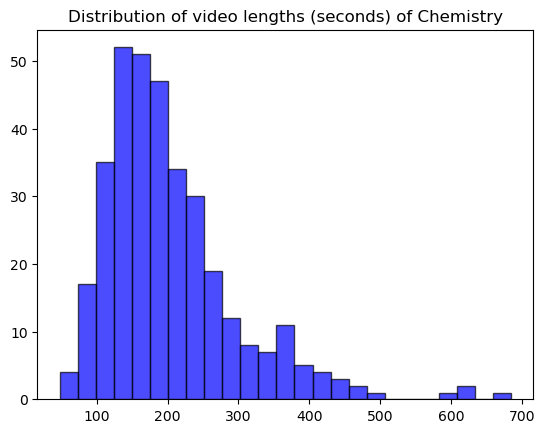

In [13]:
print(seconds_to_hhmmss(min(video_seconds)), seconds_to_hhmmss(max(video_seconds)))
plt.hist(video_seconds, bins=25, color='b', edgecolor='black', alpha=0.7)
plt.title("Distribution of video lengths (seconds) of Chemistry")
plt.show()

In [14]:
def process_text(text):
    punctuation = string.punctuation.replace("'", "")
    text = text.translate(str.maketrans('', '', punctuation))
    text = text.upper()
    return text

In [15]:
transcript_dir = "./datasets/Lip2Wav/chem/whisperx_transcripts/"
transcript_videos = glob.glob(os.path.join(transcript_dir, "*"))
transcript_videos = sorted(transcript_videos)
print(len(transcript_videos))

video_dir = transcript_videos[0]
print(video_dir)

sentences = []
sentence_durations = []
for i, video_dir in enumerate(transcript_videos):
    aligned_segments = json.load(open(os.path.join(video_dir, "aligned_segments.json")))
    if i == 0:
        print(aligned_segments[0].keys())
    video_sentences = [segment['text'] for segment in aligned_segments]
    durations = [segment['end'] - segment['start'] for segment in aligned_segments]
    sentences.extend(video_sentences)
    sentence_durations.extend(durations)

print(len(sentences))
sentence_lengths = [len(process_text(sent).split(' ')) for sent in sentences]

sentence_lengths = np.array(sentence_lengths)
sentence_durations = np.array(sentence_durations)
print(sentence_lengths)
print(sentence_durations)

346
./datasets/Lip2Wav/chem/whisperx_transcripts/--imKPteSwQ
dict_keys(['start', 'end', 'text', 'words'])
12061
[10  7 51 ... 11  5 18]
[ 2.781  0.94  12.844 ...  3.801  2.181  7.724]


In [16]:
indices = np.where(sentence_durations == sentence_durations.max())
print(indices)

for idx in indices[0]:
    print(idx)
    print(idx, f"'{sentences[idx]}'", sentence_durations[idx], sentence_lengths[idx])

(array([50]),)
50
50 ' Now, I have a linear function of natural log k and 1 over t. So if I plot ln k versus 1 over t, I expect a straight line with slope minus delta h over r and intercept delta s over r. So natural log k, I'll plot that versus 1 over t. If I have an exothermic chemical reaction, I have delta g negative.' 28.922999999999995 66


1 66


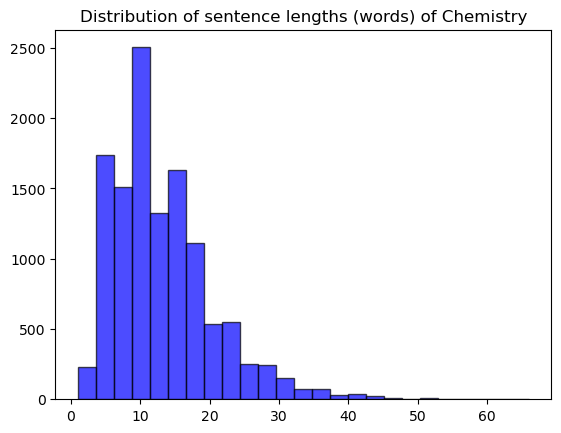

-0.020000000000010232 28.922999999999995


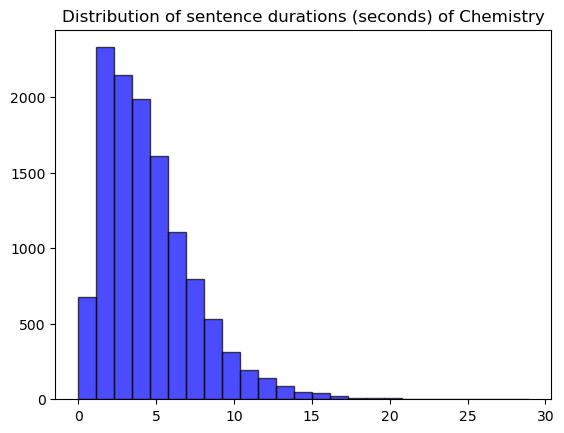

In [17]:
print(min(sentence_lengths), max(sentence_lengths))
plt.hist(sentence_lengths, bins=25, color='b', edgecolor='black', alpha=0.7)
plt.title("Distribution of sentence lengths (words) of Chemistry")
plt.show()

print(min(sentence_durations), max(sentence_durations))
plt.hist(sentence_durations, bins=25, color='b', edgecolor='black', alpha=0.7)
plt.title("Distribution of sentence durations (seconds) of Chemistry")
plt.show()

In [18]:
face_tracks_dir = './datasets/Lip2Wav/chem/face_tracks'
track_folders = glob.glob(os.path.join(face_tracks_dir, "*"))
track_folders = sorted(track_folders)
print(len(track_folders))

track_file = os.path.join(track_folders[0], 'tracks.json')
tracks_list = json.load(open(track_file))
print(tracks_list)

346
[{'input_path': '/ssd_scratch/cvit/vanshg/Lip2Wav/Dataset/chem/videos/--imKPteSwQ.mp4', 'output_path': '/ssd_scratch/cvit/vanshg/Lip2Wav/Dataset/chem/face_tracks/--imKPteSwQ/track-0.mp4', 'start_time': 0.06896551724137931, 'end_time': 18.413793103448278, 'fps': 29, 'start_frame': 2, 'end_frame': 534}, {'input_path': '/ssd_scratch/cvit/vanshg/Lip2Wav/Dataset/chem/videos/--imKPteSwQ.mp4', 'output_path': '/ssd_scratch/cvit/vanshg/Lip2Wav/Dataset/chem/face_tracks/--imKPteSwQ/track-1.mp4', 'start_time': 68.3103448275862, 'end_time': 81.93103448275862, 'fps': 29, 'start_frame': 1981, 'end_frame': 2376}, {'input_path': '/ssd_scratch/cvit/vanshg/Lip2Wav/Dataset/chem/videos/--imKPteSwQ.mp4', 'output_path': '/ssd_scratch/cvit/vanshg/Lip2Wav/Dataset/chem/face_tracks/--imKPteSwQ/track-2.mp4', 'start_time': 87.82758620689656, 'end_time': 115.27586206896552, 'fps': 29, 'start_frame': 2547, 'end_frame': 3343}]


In [7]:
def is_segment_inside_track(face_start, face_end, sent_start, sent_end, tol=0.1):
    """
    Check if a sentence/word segment lies inside a face track segment with a tolerance.

    Parameters:
    - face_start (float): Start time of the face track.
    - face_end (float): End time of the face track.
    - sent_start (float): Start time of the sentence.
    - sent_end (float): End time of the sentence.
    - tol (float): Tolerance in seconds for misalignment (default is 0.1 seconds).

    Returns:
    - bool: True if the sentence lies within the face track considering the tolerance, otherwise False.
    """
    # Check if the sentence start and end times are within the face track times with tolerance
    return (face_start - tol <= sent_start <= face_end + tol) and (face_start - tol <= sent_end <= face_end + tol)

def align_track_to_segments(track, segments, min_clip_len=0.9, verbose=False):
    """
    Gets the Sentence Segments that align with a face track

    Parameters:
    - track (dict): dictionary containing face track metadata {keys: ['start', 'end', 'input_path', 'output_path']}
    - segments (dict): dict containing sentence segments from the input video (WhisperX aligned_segment format)
    - min_clip_length (float): minimum clip length to consider (default = 0.9)

    Returns:
    - clips (dict): contains the sentence clips for this face track
    """
    track_st = track['start_time']
    track_end = track['end_time']
    if verbose:
        print(f"Track Start: {track_st} | Track End: {track_end}")

    clips = []
    tol = 0.1 # tolerance in seconds for comparing track and segments

    # Finding overlapping/contained segments for this face track
    for seg_id, segment in enumerate(segments):
        seg_st = segment['start']
        seg_end = segment['end']
        if is_segment_inside_track(track_st, track_end, seg_st, seg_end):
            # The entire sentence is covered in the face track

            # Check if the clip satisfies the min length criteria
            if (seg_end - seg_st) + 2 * tol < min_clip_len:
                continue

            clip = {'sentence': segment['text'], 'start': seg_st, 'end': seg_end,
                    'words': segment['words'], 'seg_id': seg_id}
            clips.append(clip)
            if verbose:
                print(f"ID: {seg_id} | Start: {seg_st} | End: {seg_end} | Sentence: {segment['text']}")
        elif is_segment_inside_track(track_st, track_end, seg_st, track_end) or\
             is_segment_inside_track(track_st, track_end, track_st, seg_end):
             # The sentence overlaps with the face track
            
            if verbose:
                print(f"Segment {seg_id} is overlapping with track")
            all_words = segment['words']
            seg_st = track_st
            seg_end = track_st
            word_segs = []
            words = []
            
            # Finding the list of overlapping words
            for word_id, word in enumerate(all_words):
                # Doing this because WhisperX doesn't give timestamps to numerals like "2014" or "6.1"
                word_st, word_end = word.get('start', seg_end), word.get('end', track_end)
                if is_segment_inside_track(track_st, track_end, word_st, word_end):
                    if len(words) == 0:
                        seg_st = word_st
                    seg_end = word_end
                    word_segs.append(word)
                    words.append(word['word'])
                else:
                    break
            
            # Check if the clip satisfies the min length criteria
            if (seg_end - seg_st) + 2 * tol < min_clip_len:
                continue
            sentence = ' '.join(words)
            clip = {'sentence': sentence, 'start': seg_st, 'end': seg_end,
                    'words': word_segs, 'seg_id': seg_id}
            clips.append(clip)
            if verbose:
                print(f"ID: {seg_id} | Start: {seg_st} | End: {seg_end} | Sentence: {sentence}")
        else:
            break
    
    return clips

In [19]:
video_id = 2
video_text_dir = transcript_videos[video_id]
video_track_dir = track_folders[video_id]
print(video_text_dir)
print(video_track_dir)

tracks_list = json.load(open(os.path.join(video_track_dir, "tracks.json")))
segments_list = json.load(open(os.path.join(video_text_dir, "aligned_segments.json")))

print(len(tracks_list))
print(len(segments_list))

./datasets/Lip2Wav/chem/whisperx_transcripts/-AOyf8eA1ic
./datasets/Lip2Wav/chem/face_tracks/-AOyf8eA1ic
5
24


In [20]:
tracks_clips = []

for track_id, track in enumerate(tracks_list):
    print(f"\nProcessing {track_id = }")
    clips = align_track_to_segments(track, segments_list, verbose=True)
    tracks_clips.append(clips)
    # print(tracks_list[track_id])
    # print(segments_list[2])
    # track_sents = [clip['sentence'] for clip in clips]
    # print('\n'.join(track_sents))


Processing track_id = 0
Track Start: 0.06896551724137931 | Track End: 24.06896551724138
ID: 0 | Start: 0.799 | End: 4.201 | Sentence:  We understand the relationship between free energy and temperature.
ID: 1 | Start: 4.481 | End: 22.772 | Sentence: The standard state free energy is delta H minus T delta S. So if delta H and delta S are independent of temperature, which they largely are, then delta G is a linear function of the temperature with a slope related to the entropy and an intercept related to the enthalpy.
Segment 2 is overlapping with track

Processing track_id = 1
Track Start: 34.310344827586206 | Track End: 41.310344827586206

Processing track_id = 2
Track Start: 53.275862068965516 | Track End: 74.6896551724138

Processing track_id = 3
Track Start: 83.48275862068965 | Track End: 99.72413793103448

Processing track_id = 4
Track Start: 107.96551724137932 | Track End: 214.17241379310346


In [21]:
def save_track_clips(face_track, track_id, track_clips, input_vid_dir, output_clip_dir, roundoff=False):
    video_fname = os.path.basename(face_track['input_path']).split('.')[0]

    def round_up(number):
        return math.ceil(number * 10) / 10
    
    def round_down(number):
        return math.floor(number * 10) / 10
    
    track_metadata = {
        "track_id": track_id,
        "clips": []
    }

    for clip in track_clips:
        clip_st = clip['start']
        clip_end = clip['end']
        if roundoff:
            clip_st = round_down(clip_st)
            clip_end = round_up(clip_end)
        seg_id = clip['seg_id']
        sentence = clip['sentence']

        input_video_path = os.path.join(input_vid_dir, f"{video_fname}.mp4")
        output_clip_path = os.path.join(output_clip_dir, f"{video_fname}_{track_id}_{seg_id}.mp4")

        # Save the clip 
        clip_video_ffmpeg(input_video_path, (clip_st, clip_end), output_clip_path)

        # Save the transcript
        output_txt_path = os.path.join(output_clip_dir, f"{video_fname}_{track_id}_{seg_id}.txt")

        clip_metadata = {
            "start": clip_st,
            "end": clip_end,
            "sentence": sentence,
            "segment_id": seg_id
        }
        track_metadata['clips'].append(clip_metadata)
    
    return track_metadata

### Analysing DL speaker

In [22]:
videos_dir = "./datasets/Lip2Wav/dl/raw_videos"

video_files = glob.glob(os.path.join(videos_dir, "*.mp4"))
print(len(video_files))

117


In [31]:
video_seconds = []
for idx, video_file in enumerate(video_files):
    cap = cv2.VideoCapture(video_file)
    total_frames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
    fps = cap.get(cv2.CAP_PROP_FPS)
    cap.release()
    
    total_seconds = total_frames/fps
    video_seconds.append(total_seconds)
    total_time = seconds_to_hhmmss(total_seconds)
    print(f"{video_file} | Time: {total_time} | Total Frames: {total_frames} | FPS: {fps} | Total seconds: {total_seconds}")

./datasets/Lip2Wav/dl/raw_videos/Vc-jG_LdOLw.mp4 | Time: 00:14:11.160 | Total Frames: 21279.0 | FPS: 25.0 | Total seconds: 851.16
./datasets/Lip2Wav/dl/raw_videos/HnaBcIL2shc.mp4 | Time: 00:11:53.000 | Total Frames: 17825.0 | FPS: 25.0 | Total seconds: 713.0
./datasets/Lip2Wav/dl/raw_videos/hMkRDNzH9vs.mp4 | Time: 00:26:49.960 | Total Frames: 40249.0 | FPS: 25.0 | Total seconds: 1609.96
./datasets/Lip2Wav/dl/raw_videos/-7l-Pl_pwu4.mp4 | Time: 00:04:54.480 | Total Frames: 7362.0 | FPS: 25.0 | Total seconds: 294.48
./datasets/Lip2Wav/dl/raw_videos/PMv8C-Ws1b8.mp4 | Time: 00:08:10.000 | Total Frames: 12250.0 | FPS: 25.0 | Total seconds: 490.0
./datasets/Lip2Wav/dl/raw_videos/BW7P1fvnAWk.mp4 | Time: 00:08:38.560 | Total Frames: 12964.0 | FPS: 25.0 | Total seconds: 518.56
./datasets/Lip2Wav/dl/raw_videos/DirgOcmERwA.mp4 | Time: 00:12:44.680 | Total Frames: 19117.0 | FPS: 25.0 | Total seconds: 764.68
./datasets/Lip2Wav/dl/raw_videos/4TC5s_xNKSs.mp4 | Time: 00:06:57.680 | Total Frames: 10442.

In [30]:
video_seconds = np.array(video_seconds)
video_ids = np.where(video_seconds == video_seconds.max())
video_ids = video_ids[0]

print(video_files[video_ids[0]])

./datasets/Lip2Wav/dl/raw_videos/wPz3MPl5jvY.mp4


00:01:31.000 00:52:32.200


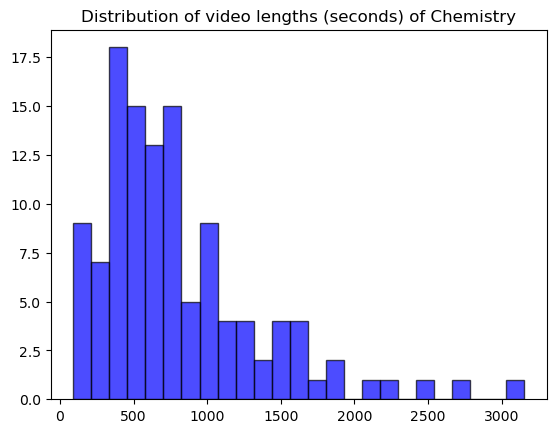

In [24]:
print(seconds_to_hhmmss(min(video_seconds)), seconds_to_hhmmss(max(video_seconds)))
plt.hist(video_seconds, bins=25, color='b', edgecolor='black', alpha=0.7)
plt.title("Distribution of video lengths (seconds) of Chemistry")
plt.show()